In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import os
os.chdir("/content/gdrive/My Drive/Face Mask")
!pwd

/content/gdrive/My Drive/Face Mask


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [21]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

Data_dir = "dataset/"
CATEGORIES = ["with_mask", "without_mask"]

In [26]:
data = []
labels = []

for category in CATEGORIES:
    path = Data_dir + category
    print("loading from ", path)
    for i, img in enumerate(os.listdir(path)):
        if i % 100 == 0:
            print("Images Loaded", i)
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

loading from  dataset/with_mask
Images Loaded 0
Images Loaded 100


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Images Loaded 200
Images Loaded 300
Images Loaded 400
Images Loaded 500
Images Loaded 600
Images Loaded 700
Images Loaded 800
Images Loaded 900
Images Loaded 1000
Images Loaded 1100
Images Loaded 1200
Images Loaded 1300
Images Loaded 1400
Images Loaded 1500
Images Loaded 1600
Images Loaded 1700
Images Loaded 1800
Images Loaded 1900
loading from  dataset/without_mask
Images Loaded 0
Images Loaded 100
Images Loaded 200
Images Loaded 300
Images Loaded 400
Images Loaded 500
Images Loaded 600
Images Loaded 700
Images Loaded 800
Images Loaded 900
Images Loaded 1000
Images Loaded 1100
Images Loaded 1200
Images Loaded 1300
Images Loaded 1400
Images Loaded 1500
Images Loaded 1600
Images Loaded 1700
Images Loaded 1800
Images Loaded 1900


In [28]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)
labels[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [29]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [32]:
def get_model():
  # load the MobileNetV2 network
  baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
  
  baseModel.trainable = False

  # construct the head of the model that will be placed on top of the
  # the base model
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dropout(0.5)(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = Model(inputs=baseModel.input, outputs=headModel)
  return model
  

In [33]:
model = get_model()
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [34]:
history = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS,
	 validation_data=(testX, testY), validation_steps=len(testX) // BS, 	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 40s 424ms/step - loss: 0.3062 - accuracy: 0.8659 - val_loss: 0.1084 - val_accuracy: 0.9687
Epoch 2/20
95/95 [==============================] - 38s 404ms/step - loss: 0.1085 - accuracy: 0.9618 - val_loss: 0.0626 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 38s 401ms/step - loss: 0.0728 - accuracy: 0.9773 - val_loss: 0.0654 - val_accuracy: 0.9739
Epoch 4/20
95/95 [==============================] - 38s 396ms/step - loss: 0.0672 - accuracy: 0.9789 - val_loss: 0.0542 - val_accuracy: 0.9791
Epoch 5/20
95/95 [==============================] - 37s 393ms/step - loss: 0.0606 - accuracy: 0.9796 - val_loss: 0.0457 - val_accuracy: 0.9817
Epoch 6/20
95/95 [==============================] - 38s 401ms/step - loss: 0.0590 - accuracy: 0.9789 - val_loss: 0.0339 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 38s 399ms/step - loss: 0.0527 - accuracy: 0.9815 - val_loss: 0.0359 - val_accuracy: 0.9883

In [35]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [36]:
model.save("face_mask_detector.model", save_format="h5")

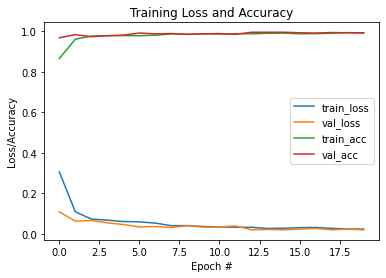

In [37]:
plt.figure()
plt.plot(range(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(range(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(range(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(range(0, EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [35]:
# because cv2 video streaming does happen easily on ipynb notebooks so make another file and calling it here.
# it will open the camera
# detect our face
# make prediction using our face mask model and will show
!python detect_mask_video.py

Starting video stream...

2020-07-28 20:37:56.700478: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-07-28 20:37:56.700759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-07-28 20:37:58.306986: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2020-07-28 20:37:58.767463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce MX130 computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 2.00GiB deviceMemoryBandwidth: 37.33GiB/s
2020-07-28 20:37:58.768272: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-07-28 20:37:58.768889: W tensorflow/stream_executor/platform/de

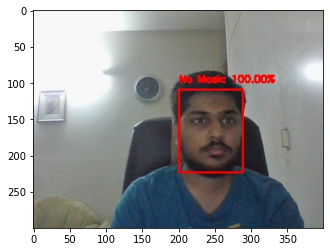

In [38]:
img = Image.open("No Mask.jpg")
plt.imshow(img)

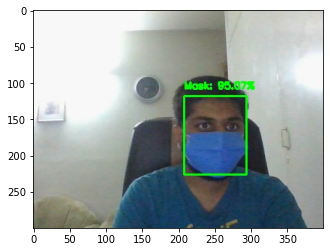

In [39]:
img = Image.open("Mask.jpg")
plt.imshow(img)